![Banner](images/banner.jpeg)

# AutoML Competitions: a Meta-Learning Perspective

**Anonymous authors**

This notebook contains all experiments and plots presented in the paper "AutoML Competitions: a Meta-Learning Perspective" submitted to [AutoML-Conf 2022](https://automl.cc/).

Automated Machine Learning (AutoML) competitions seek to uncover best solutions to multiple tasks, which might generalize to similar tasks, without human intervention: a meta-learning problem. By casting the problem of judging such competitions as a meta-learning problem, this paper provide a theoretical analysis, which outlines the danger of over-fitting the tasks of a competition. Such (meta-)over-fitting worsens as the number 𝑛 of competition participants increases. We propose a simple scheme to choose the winner, which alleviates this problem, in two-phase competitions having an identical number of similar tasks: the top-k algorithm.

In this notebook, we evaluate the top-k algorithm in various settings: on artificial data and on real data.

**Notebook outline:**

**[1. Artificial / theoretical case](#part1)**

**[2. Real data](#part2)**
- [2.1. One task case](#partA)
- [2.2. Multi-task (AutoML) case](#partB)

In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import comb, factorial # combination (binomial coefficient) and factorial function
from numpy.linalg.linalg import matrix_power # matrix power (Chapman-Kolmogorov equation)
import sys
sys.path.append('../ranky')
import pickle
import ranky as rk # select_k_best is implemented in Ranky (https://github.com/didayolo/ranky)

%load_ext autoreload
%autoreload 2

<a id='part1'></a>
# 1. Artificial / theoretical case

Two rankings D and F (representing developmment and final leaderboards) are generated by applying $s$ random swaps on a ground truth ranking $g = [1, 2, ..., n]$.

### acc(k=1) = acc(k=n) = ?

Empirical estimation of $acc(k=n)$, the probability that the winner stays in the first position after the $s$ random swaps, as a function of $\phi = \frac{s}{n}$.

### Markov chain approach
We model the movements of a candidate during the swaps using a Markov chain.

We fix the probability of changing state to $p= \frac{2}{n-1}$

In the Markov chain, we have a "hard wall" below 0 so the "walker" will either stay at 0 or move up to 1
(+ another wall above n)

We obtain the probability of going from the position a to the position b after $s$ swaps by modelling our problem using the Chapman-Kolmogorov equation.

![Markov chain scheme](images/markov_chain.png)

with $p = \frac{1}{n-1}$

In [2]:
def transition_matrix(n):
    ''' The transition matrix of the Markov chain.
    
    The transitions lead, from any state, to a better position or a worst position with a probability of 1/(n-1)
    as showed in the scheme.
    
    Examples:
    
                            [[1/2, 1/2, 0],     
    transition_matrix(3) =  [1/2,  0, 1/2],
                            [0,  1/2, 1/2]]
                            
                            [[2/3, 1/3,  0],     
    transition_matrix(4) =  [1/3, 1/3, 1/3],
                            [0,  1/3,  2/3]]
    '''
    if n == 1:
        T = [1]
    elif n == 2:
        T = [[0, 1], [1, 0]]
    else: # n >= 3
        p = 1 / (n-1)
        T = []
        first = [0 for _ in range(n)]
        first[0] = 1 - p
        first[1] = p
        T.append(first)
        for i in range(n-2):
            row = [0 for _ in range(n)]
            row[i] = p
            row[i+1] = 1 - (2*p)
            row[i+2] = p
            T.append(row)
        last = [0 for _ in range(n)]
        last[n-2] = p
        last[n-1] = 1 - p
        T.append(last)    
    return np.array(T)

def proba_move(a, b, n, N, T=None):
    ''' Probability of ending up in position b from the starting position a after N swaps, in a list of n elements.
    '''
    if n == 1:
        return 1 # can only win if alone
    if T is None: # avoid re-computing T
        T = transition_matrix(n)
    TN = matrix_power(T, N)
    return TN[a][b]

def proba_top_k(a, k, n, N, T=None):
    ''' Probability of ending up in positions [0, k] from the starting position a after N moves, in a list of n elements.
    '''
    return np.sum([proba_move(a, b, n, N, T=T) for b in range(k)])

Let's compare the empirical probability that the true winner wins to the predicted $acc(k=1)$

In [16]:
# Data points
_phi = []
_pk = []
_markov = []

# Parameters
trials = 10000
_n = [20]
_N = list(range(20*5))

for n in _n:
    for N in tqdm(_N):
        # Artificial judges
        g = rk.generator.SwapGenerator()
        g.fit(list(range(n)))
        # Compute the rank of the true winner
        d = pd.DataFrame(g.sample(N=N, n=trials))
        winner_ranks = d.loc(0)[0]
        pk = winner_ranks.isin([0]).sum(axis=0) / trials
        # Store values
        _phi.append(N/n)
        _pk.append(pk)
        _markov.append(proba_move(0, 0, n, N))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:20<00:00,  2.00s/it]


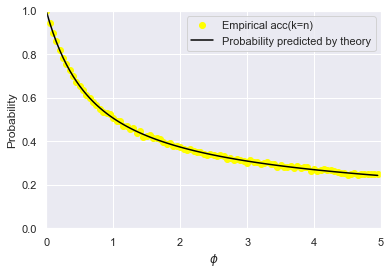

In [18]:
# PLOT
plt.plot(_phi, _pk, 'o', label='Empirical acc(k=n)', color='yellow')
plt.plot(_phi, _markov, '-', label='Probability predicted by theory', color='black')
plt.xlim((0, 5))
plt.ylim((0, 1))
plt.xlabel('$\phi$')
plt.ylabel('Probability')
plt.legend()
plt.show()

# acc(k)

Empirical estimation of $k* = argmax ~ acc(k)$ as a function of $\phi$. 

$k*$ is the optimal argument of select-k-best such that the probability of selecting the winner is maximized.

acc(k) = P(true winner ranked first | true winner in top k) * P(true winner in top k)

To approximate P(tw ranked first | tw in top k), we compute:
- The probability that the true winner ends up first (acc(k=1))
- For each candidates, (1 - P(in top k)) x P(ranked first)

In [4]:
def approx_pk(n, N, k):
    ''' Approximation of acc(k), the probability that the true winner is selected by select-k-best method.
    '''
    T, T1 = transition_matrix(n), transition_matrix(n-1) # optimize computation
    prior = proba_top_k(0, k, n, N, T=T) # P(true winner in top k)
    pk = 1 
    for e in range(1, n): # all other candidates
        # acc(K) is decreased when another candidate win (and is in topk)
        pk -= proba_top_k(e-1, k-1, n-1, N, T=T1) * proba_move(e, 0, n, N, T=T)
    return (pk * prior)

def approx_k_star(n, N):
    return np.argmax([approx_pk(n, N, k) for k in range(n)])

def select_winner(topk, F):
    """ Return the first element from topk in F.
    """
    for e in F:
        if e in topk:
            return e

def evaluate_scores_artificial(n, N, trials=200, return_d=False):
    """ Estimate empirically the accuracy of top-k on artificial data.
    
    Return arrays of scores.
    
    If return_d, estimate empirically the average of kendall tau distance between D and F, on artificial data.
    """
    accs = np.zeros(n) # number of wins
    ranks = np.zeros(n) # rank score
    in_topk = np.zeros(n) # number of times in topk
    _k = range(1, n+1)
    d = 0
    g = rk.generator.SwapGenerator() # Artificial judges
    g.fit(list(range(n)))
    true_g = g.sample(N=0)
    for _ in range(trials):
        D = g.sample(N=N, n=1)
        F = g.sample(N=N, n=1)
        for k in _k:
            winner = select_winner(D[:k], F) # selected by top-k
            if 0 in D[:k]: # in top-k
                in_topk[k-1] += 1
            if winner == 0: # The selection went well
                accs[k-1] += 1 # count when the true winner wins  
            ranks[k-1] += (true_g[winner]) / (n-1) # normalized true rank of the winner
        if return_d: # estimation of Kendall tau distance
            d += rk.kendall_tau_distance(D, F, ties=False)
    if return_d:
        return accs/trials, ranks, in_topk/trials, d/trials
    return accs/trials, ranks/trials, in_topk/trials

def get_k_star(accs):
    """ Estimate k* (optimal value of k) from scores on artificial data.
    """
    n = len(accs)
    _k = range(1, n+1)
    return _k[np.argmax(accs)]
    
def get_average_k_star(n, N, trials=20, acc_trials=20):
    """ Estimate average k* (optimal value of k) from scores on artificial data.
    
    Returns lists of scores.
    """
    _k_star, _d = [], []
    for _ in range(trials):
        accs, _, _, d = evaluate_scores_artificial(n, N, trials=acc_trials, return_d=True)
        _k_star.append(get_k_star(accs)) # k*
        _d.append(d)
    return _k_star, _d

def evaluate_d(n, N, trials=200):
    """ Estimate empirically the average of kendall tau distance between D and F, on artificial data.
    """
    g = rk.generator.SwapGenerator()
    g.fit(list(range(n)))
    _d = []
    for _ in range(trials):
        # Artificial judges
        # Compute the rank of the true winner
        D = g.sample(N=N, n=1)
        F = g.sample(N=N, n=1)
        _d.append(rk.kendall_tau_distance(D, F))
    return np.mean(_d)

#### What is the behavior of $k*$ when $s$ (or $d$) varies?

In [155]:
# k*
# Compare k* to phi (and to Kendall distance between D and F)
def evaluate_kendall(n, Nmax=100, step=1, trials=20, acc_trials=20, ks=True, approx_markov=False):
    _phi, _d, _k_star, _stk_star, _maxk_star, _approx_k_star = [], [], [], [], [], []
    for N in tqdm(range(0, Nmax, step)):
        if ks:
            k_star, d = get_average_k_star(n, N, trials=trials, acc_trials=acc_trials)
            k_star, stk_star, d = np.mean(k_star), np.std(k_star), np.mean(d)
            _k_star.append(k_star)
            _stk_star.append(stk_star)
        else:
            d = evaluate_d(n, N, trials=trials)
        _d.append(d / n)
        _phi.append(N / n)
        if approx_markov: # compute the approximation using markov chain
            _approx_k_star.append(approx_k_star(n, N))
    if ks:
        _k_star, _stk_star = np.array(_k_star), np.array(_stk_star)
    return _d, _k_star, _stk_star, _maxk_star, _approx_k_star   
    
def plot_experiment_kendall(n, Nmax, _d, _k_star, _stk_star, _maxk_star, _approx_k_star, ks=True, approx_markov=False):
    # Plots
    # Plot Kendall tau distance
    if ks:
        plt.plot(_d, _k_star, 'x-', label='Empiricial k*', color='tab:blue')
        # TODO DISPLAY STD
        plt.fill_between(_d, _k_star - _stk_star, _k_star + _stk_star, color='blue', alpha=0.1) # error bars
    if approx_markov: # plot the approximation
        plt.plot(_d, _approx_k_star, '-', label='Approximated k*', color='tab:green')
    # RULE OF THUMBS: k* ~= 2d/n + 1
    plt.plot(_d, np.array(_d) * 2 + 1, '-', label='(2d / n) + 1', color='tab:grey')
    # RULE OF THUMBS: k* ~= d/n + 1
    plt.plot(_d, np.array(_d) + 1, '-', label='(d / n) + 1', color='tab:pink')
    plt.xlabel('$d/n$')
    plt.ylabel('$k*$')
    plt.title('$n = {}, ~~ s \in [0, {}]$'.format(n, Nmax))
    plt.legend()
    plt.show()
    # Plot PHI
    if False:
        if ks:
            plt.plot(_phi, _k_star, 'x', label='Empirical k*')
        ##plt.plot(_phi, _approx_k_star, '-', label='Approximated k*')
        plt.xlabel('$\phi$')
        plt.ylabel('k*')
        #plt.ylim((0, n+1))
        plt.legend()
        plt.show()
        
def experiment_kendall(n, Nmax=100, step=1, trials=20, acc_trials=20, ks=True, approx_markov=False, save=False):
    # TODO: save results to plot later
    # save: False or filename
    _d, _k_star, _stk_star, _maxk_star, _approx_k_star = evaluate_kendall(n, Nmax=Nmax)
    if save:
        filename = os.path.join('data/results', save)
        pickle.dump([n, Nmax, _d, _k_star, _stk_star, _maxk_star, _approx_k_star], open(filename, "wb"))
        print('Results saved in {}'.format(filename))
    # PLOT
    plot_experiment_kendall(n, Nmax, _d, _k_star, _stk_star, _maxk_star, _approx_k_star, ks=ks, approx_markov=approx_markov)
    
def load_experiment_kendall(filename):
    filename = os.path.join('data/results', filename)
    n, Nmax, _d, _k_star, _stk_star, _maxk_star, _approx_k_star = pickle.load(open(filename,"rb"))
    # PLOT
    plot_experiment_kendall(n, Nmax, _d, _k_star, _stk_star, _maxk_star, _approx_k_star)
    

### TODO: 
Sur la même courbe (code qui enregistre les valeurs)
- 4 points empiriques
- différentes valeurs de n

Aussi
- k* en fonction de rank error (pas que NLA)
- error bars bootstrap

In [143]:
experiment_kendall(20, Nmax=10000, step=100, trials=1000, acc_trials=100, save='kendall_n20')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:08:07<00:00, 40.87s/it]

n = 100
s max = 10000


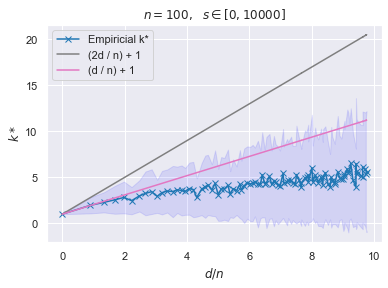

In [95]:
experiment_kendall(100, Nmax=10000, step=100, trials=100, acc_trials=100, save='kendall_n100')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:21:41<00:00, 49.02s/it]

n = 200
s max = 10000


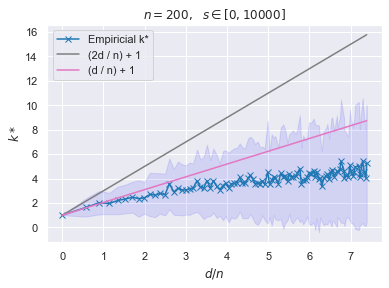

In [96]:
experiment_kendall(200, Nmax=10000, step=100, trials=100, acc_trials=100, save='kendall_n200')

#### Empirical evaluation of $acc(k)$

In [226]:
def artificial_experiment(n, N, trials=200):
    """ Compute acc(k), error etc. when k varies on the artificial problem.
    """
    _k = range(1, n+1)
    accs, ranks, in_topk, d = evaluate_scores_artificial(n, N, trials=trials, return_d=True) # empirical accuracy
    #approx = [approx_pk(n, N, k) for k in _k]           # approximation
    t1 = [proba_top_k(0, k, n, N) for k in _k]
    t2 = accs / in_topk
    # convert to -log
    accs, t1, t2 = -np.log(accs), -np.log(t1), -np.log(t2) 
    ### PLOTS ###
    # NLA PLOT
    kstar = np.min(accs) # min because -log
    kstar_i = np.argmin(accs) + 1
    # k* score
    plt.plot([1, _k[-1]], [kstar, kstar], '-', label='k*', color='tab:blue', alpha=0.35) # horizontal
    plt.plot([kstar_i, kstar_i], [0, accs[0]], '-', label='k*', color='tab:blue', alpha=0.35) # vertical
    # green : generalization gap / proba(gagnant F\D | top-k)
    plt.plot(_k, t2, 'o-', label='True winner selected when in top-k', color='tab:green')
    # red : train error / proba(top-k)
    plt.plot(_k, t1, 'o-', label='True winner in top-k', color='tab:red')
    # blue : test error / acc(k)
    plt.plot(_k, accs, 'o-', label='Empirical meta-test accuracy', color='tab:blue')
    plt.xlabel('k')
    plt.ylabel('NLA')
    plt.title('$s = {}, ~~ d = {}$'.format(N, round(d, 2)))
    plt.show()
    #print('phi = {}'.format(N / n))
    #print('d/n = {}'.format(d / n))
    #plt.xlim(left=0)
    #plt.legend()
    
    # RANK PLOT
    if False:
        plt.plot(_k, ranks, 'o-', label='Empirical meta-test rank error', color='tab:blue')
        plt.xlabel('k')
        plt.ylabel('Error')
        plt.ylim(bottom=0)
        plt.title('$s = {}$'.format(N))
        plt.legend()
        plt.show()
        
    #approx = -np.log(approx)
    #plt.plot(_k, approx, '-', label='Approximation (formula)', color='tab:grey')

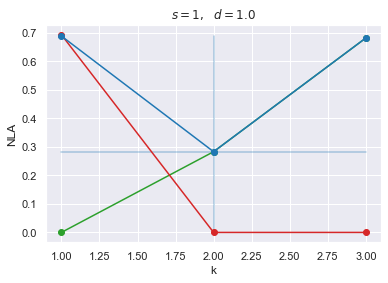

In [227]:
# cas n=3, s=1
artificial_experiment(3, 1, trials=20000)

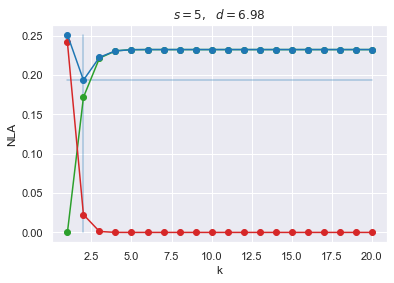

In [232]:
artificial_experiment(20, 5, trials=10000)

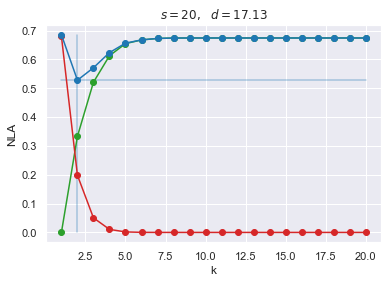

In [233]:
artificial_experiment(20, 20, trials=10000)

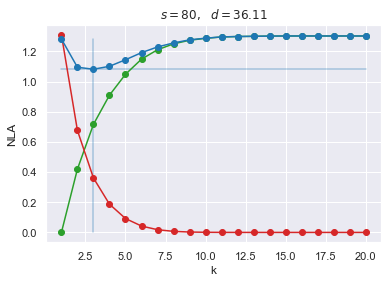

In [234]:
artificial_experiment(20, 80, trials=10000)

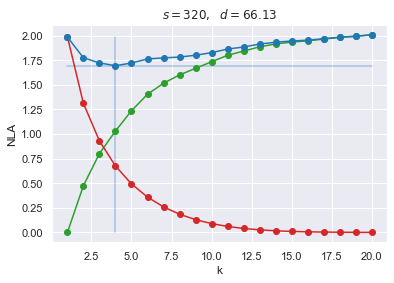

In [235]:
artificial_experiment(20, 320, trials=10000)

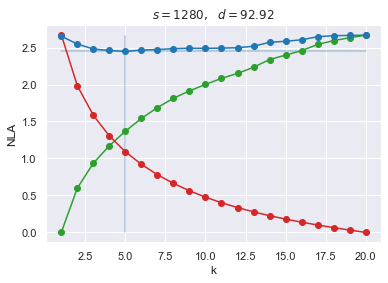

In [236]:
artificial_experiment(20, 1280, trials=10000)

In [ ]:
# Monter s encore plus pour voir si k* > n/2 est possible?

<a id='part2'></a>
# 2. Real data

The following code defines experiments with real data for sections [2.1](#partA) and [2.2](#partB) of the notebook.

In [228]:
def evaluate_scores_real(M, trials=200, ranks=False, return_d=False):
    """ Evaluate accuracy and score of top-k method on real data.
    
    From a matrix of scores M (rows are candidates, columns are judges).
    Bootstrap (shuffle), then split in 3 and compute the acc/score.
    Same code for 2. and 3.
    
    Return the scores (not averaged)
    
    If return_d, estimate the normalized tau distance between D and F and return it
    """
    M = np.array(M)
    n, m = M.shape # n candidates (rows), m judges (columns)
    tr_scores, te_scores, tr_ranks, te_ranks, tr_accs, te_accs = ([[] for _ in range(n)], # meta-train scores
                                                                  [[] for _ in range(n)], # meta-test scores 
                                                                  [[] for _ in range(n)], # meta-train ranks
                                                                  [[] for _ in range(n)], # meta-test ranks
                                                                  [[] for _ in range(n)], # meta-train accuracy
                                                                  [[] for _ in range(n)]) # meta-test accuracy
    d = 0 # kendall distance
    th = int(m/3)
    for _ in tqdm(range(trials)):
        _M = rk.bootstrap(M, axis=1) # shuffle judges
        D, F, P = _M[:,:th], _M[:,th:2*th], _M[:,2*th:] # dev, final, post
        if ranks: # this way the average score will be the aveage rank instead
            D, F, P = ((rk.rank(D, reverse=True) - 1) / (n-1), 
                       (rk.rank(F, reverse=True) - 1) / (n-1), 
                       (rk.rank(P, reverse=True) - 1) / (n-1))
        D, F, P = rk.score(D), rk.score(F), rk.score(P) # average
        F_rank, P_rank = rk.rank(F), rk.rank(P) # to compute rank errors later
        if return_d:
            d += rk.kendall_tau_distance(D, F)
            #d += rk.corr(D, F, method='kendalltau') # kendall tau between -1 and 1
        for k in range(1, n+1):
            top_k = rk.select_k_best(D, k=k) # list of k best in D
            winner = rk.top_k_method(D, F, k=k) # index of winner selected
            # train score: best of F[top_k], score or average rank score
            tr_scores[k-1].append(np.max(F[top_k]))
            # test score: score of the selected winner in P
            te_scores[k-1].append(P[winner])
            # train rank: normalized rank of the winner in F
            tr_ranks[k-1].append((F_rank[winner] - 1) / (n-1))
            # test rank: normalized rank of the winner in P
            te_ranks[k-1].append((P_rank[winner] - 1) / (n-1))
            # train accuracy: frequency of selecting the best of F
            tr_accs[k-1].append(int(winner == np.argmax(F)))
            # test accuracy: frequency of selecting the best of P
            te_accs[k-1].append(int(winner == np.argmax(P)))
    if return_d:
        return tr_scores, te_scores, tr_ranks, te_ranks, tr_accs, te_accs, (d / trials)
    return tr_scores, te_scores, tr_ranks, te_ranks, tr_accs, te_accs

def standard_error(scores): # OBSOLETE /!\
    """ Compute 2 * SE from scores of shape (k, trials)
    """
    trials = np.shape(scores)[1]
    std = np.std(scores, axis=1)
    stre = 2 * std / np.sqrt(trials)
    return stre

def standard_dev(scores):
    """ STD from scores of shape (k, trials)
    """
    return [np.std(k)/2 for k in scores]

def quartile(scores):
    """ First and third quartile from scores of shape (k, trials)
    """
    q1 = [np.quantile(k, 0.25) for k in scores] # first quartile
    q3 = [np.quantile(k, 0.75) for k in scores] # third quartile
    return q1, q3

def experiment(data, trials=200, ranks=False, show_score_plot=False, show_acc_plot=False, title=None, loc='upper right'):
    """ Run experiments on real data.
    
    If ranks = True, judges are converted to rank (useful when judges are datasets)
    """
    # Top-k scores
    _k = range(1, data.shape[0]+1)
    tr, te, trr, ter, tracc, teacc, d = evaluate_scores_real(data, ranks=ranks, trials=trials, return_d=True)
    mtr, mte, mtrr, mter, mtracc, mteacc = np.mean(tr, axis=1), np.mean(te, axis=1), np.mean(trr, axis=1), np.mean(ter, axis=1), np.mean(tracc, axis=1), np.mean(teacc, axis=1)
    k_star = np.argmin(mter) + 1
    
    # Plot RANKS
    #qtrr1, qtrr3 = quartile(trr)
    #qter1, qter3 = quartile(ter)
    kstar_rank = np.min(mter) # min because "rank score"
    # Scale and marker size for OpenML
    size = None # marker size
    if data.shape[0] > 200:
        size = 3 # marker size
        def forward(x):
            return x**(1/2)
        def inverse(x):
            return x**2
        fig, ax = plt.subplots(1, 1)
        ax.set_xscale('function', functions=(forward, inverse))
    # PLOT
    # K*
    plt.plot([1, _k[-1]], [kstar_rank, kstar_rank], '-', label='k*', color='tab:blue', alpha=0.35) # k star horizontal
    plt.plot([k_star, k_star], [0, max(mtrr[0], mter[0])], '-', label='k*', color='tab:blue', alpha=0.35) # k star vertical
    # GREEN : GENERALIZATION GAP
    plt.plot(_k, np.abs(mtrr - mter), 'o-', label='Generalization gap', color='tab:green', markersize=size) # generalization gap
    # RED : TRAIN
    plt.plot(_k, mtrr, 'o-', label='Meta-train', color='tab:red', markersize=size) # values
    # BLUE : TEST
    plt.plot(_k, mter, 'o-', label='Meta-test', color='tab:blue', markersize=size) # values
    plt.xlabel('k')
    plt.ylabel('Rank error')
    plt.title(r'{}, $\frac{{d}}{{n}} = {}$'.format(title, round(d / data.shape[0], 2)))
    plt.show()
    print('k* = {}'.format(k_star))
    #plt.fill_between(_k, mtrr-qtrr1, mtrr+qtrr3, color='red', alpha=0.1) # error bars # TMP WARNING /!\
    #plt.fill_between(_k, mter-qter1, mter+qter3, color='blue', alpha=0.1) # error bars
    #plt.legend(loc=loc)
    #print('d/n = {}'.format(d / data.shape[0]))
    
    # Plot SCORES
    if show_score_plot:
        #qtr1, qtr3 = quartile(tr)
        #qte1, qte3 = quartile(te)
        plt.plot(_k, mtr, 'o-', label='Meta-train', color='tab:red')
        plt.plot(_k, mte, 'o-', label='Meta-test', color='tab:blue')
        plt.xlabel('k')
        plt.ylabel('Average score')
        plt.legend(loc='center right')
        plt.show()
        
    # Plot ACCURACY
    if show_acc_plot:
        mtracc, mteacc = -np.log(mtracc), -np.log(mteacc)
        #qtracc1, qtracc3 = -np.log(quartile(tracc))
        #qteacc1, qteacc3 = -np.log(quartile(teacc))
        plt.plot(_k, mtracc, 'o-', label='Meta-train', color='tab:red')
        #plt.fill_between(_k, qtracc1, qtracc3, color='red', alpha=0.1) # error bars
        plt.plot(_k, mteacc, 'o-', label='Meta-test', color='tab:blue')
        #plt.fill_between(_k, qteacc1, qteacc3, color='blue', alpha=0.1) # error bars
        plt.plot(_k, np.abs(mtracc - mteacc), 'o-', label='Generalization gap', color='tab:green', markersize=size)
        plt.xlabel('k')
        plt.ylabel('NLA')
        #plt.legend(loc='center right')
        plt.show()

<a id='partA'></a>
# 2.1. One task case

##### Evaluate select-K-best on various 1 task problems

In [6]:
def create_score_matrix(dataset, path, reference, candidates, metric):
    # Create matrix
    M = []
    ref_file = os.path.join(path, reference, dataset+'_test.solution')
    ref = pd.read_csv(ref_file, sep=" ", header=None)
    ref = ref.drop([ref.columns[-1]], axis=1) # fix problem in format
    # Development, Final and Post-challenge phases
    for candidate in candidates:
        files = glob(os.path.join(path, candidate, dataset+'_test*.predict'))
        pred_file = sorted(files)[-1] # last predictions
        pred = pd.read_csv(pred_file, sep=" ", header=None)
        pred = pred.drop([pred.columns[-1]], axis=1)  
        l = [rk.metric([ref.loc[i]], [pred.loc[i]], method=metric) for i in range(ref.shape[0])] # DIRTY
        M.append(l)
    M = pd.DataFrame(M)
    M.index = candidates
    return M

In [12]:
path = 'data/automl_predictions'
reference = 'reference'
candidates = ['aad_freiburg', 'gaussian_nb_default', 'abhishek', 'jameslloyd',
              'rf_autosklearn', 'asml_intel', 'knn_autosklearn', 'rf_default',
              'baseline', 'knn_default', 'sgd_autosklearn', 'lise_sun', 'sgd_default', 'djajetic', 'marc_boulle', 'gaussian_nb_autosklearn']
# 'bayesian_ridge_default'
datasets = ['fabert', 'adult', 'alexis', 'arturo', 'digits']
metric = 'accuracy'

fabert


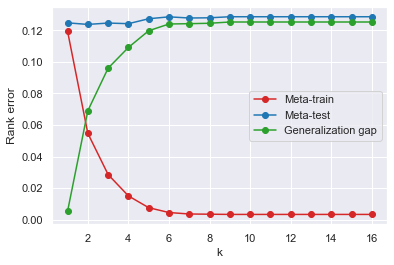

d = 2.45175
adult


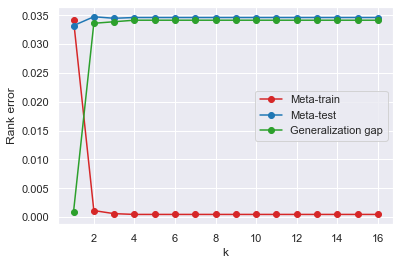

d = 1.6225
alexis


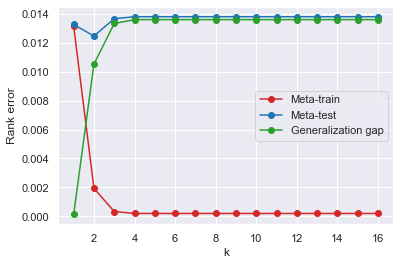

d = 2.115875
arturo


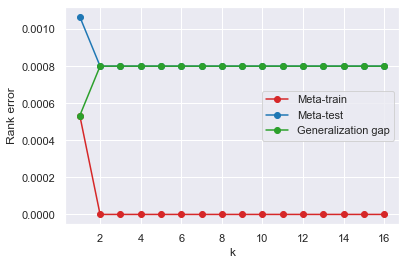

d = 1.28475
digits


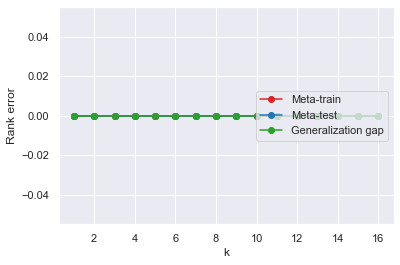

d = 0.011875


In [16]:
for dataset in datasets:
    print(dataset)
    data = create_score_matrix(dataset, path, reference, candidates, metric)
    experiment(data, trials=500, ranks=False, show_score_plot=False)

<a id='partB'></a>
# 2.2 Multi-task (AutoML) case

### TODO: k* et predicted k* dans le plot (ou pas?)

In [160]:
benchmarks = ['AutoDL-AUC.data', 'AutoML.data', 'Statlog.data', 'OpenML.data']
path = 'data/benchmarks'

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:26<00:00, 115.82it/s]


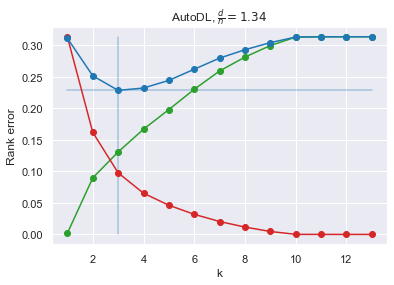

k* = 3


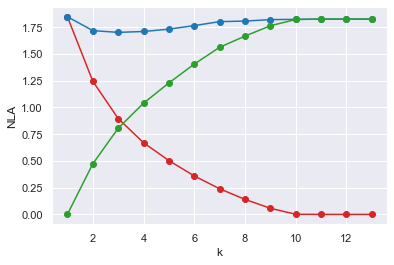

In [229]:
# AutoDL
data = pd.read_csv(os.path.join(path, benchmarks[0]), header=None, sep=' ').T
experiment(data, title='AutoDL', trials=10000, show_acc_plot=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:52<00:00, 88.94it/s]


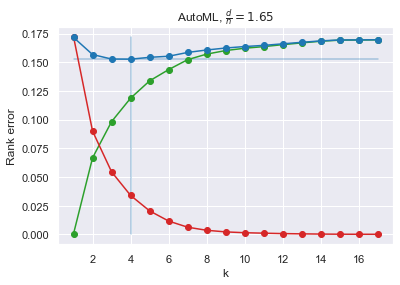

k* = 4


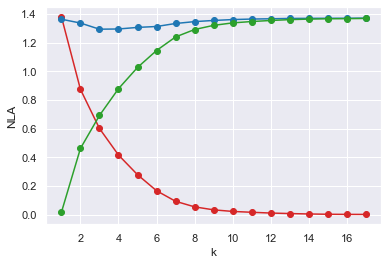

In [230]:
# AutoML
data = pd.read_csv(os.path.join(path, benchmarks[1]), header=None, sep=' ').T
experiment(data, title='AutoML', show_acc_plot=True, trials=10000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:31<00:00, 65.89it/s]


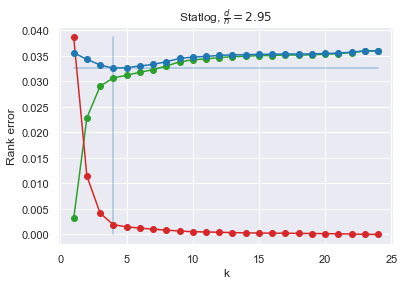

k* = 4


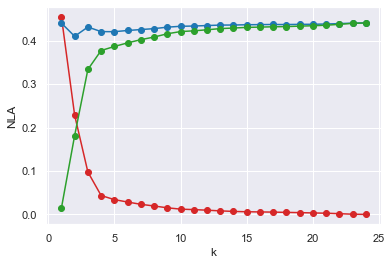

In [231]:
# Statlog
data = pd.read_csv(os.path.join(path, benchmarks[2]), header=None, sep=' ').T
experiment(data, title='Statlog', show_acc_plot=True, trials=10000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [33:59<00:00,  4.90it/s]


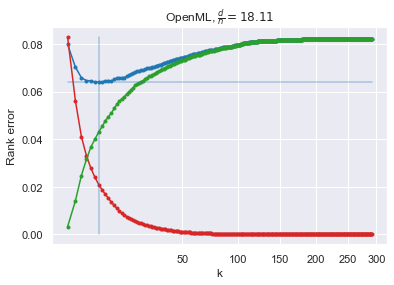

k* = 7


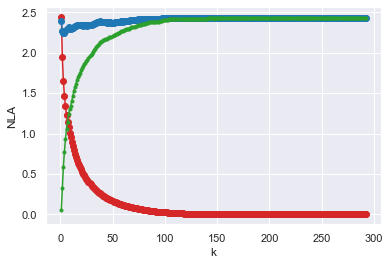

In [216]:
# OpenML
data = pd.read_csv(os.path.join(path, benchmarks[3]), header=None, sep=' ').T
experiment(data, title='OpenML', show_acc_plot=True, trials=10000, loc='center right')

</br>
</br>
</br>
</br>

# Artificial data

# $\frac{s}{n}$ vs $\frac{d}{n}$

In [609]:
# TMP
# Trying to understand relation between s and d
# Encore une chaine de Markov

def tm(n):
    ''' The transition matrix of the Markov chain.
    
    Pairs that increase or decrease the Kendall distance.
    
    Illustrative but impossible example
    
                               [[0,        f(0),        0],     
    transition_matrix(...) =    [1 - f(1),  0,       f(1)],
                                [0,         1 - f(2),   0]]
    '''
    if n == 1:
        T = [1]
    else: # n >= 2
        T = []
        c = comb(n, 2) + 1
        T = []
        for i in range(c):
            row = [0 for _ in range(c)]
            if i > 0:
                row[i-1] = 1 - pp(n, i)
            if i < c-1:
                row[i+1] = pp(n, i)
            T.append(row) 
    return np.array(T)

def kd(n, N):
    ''' Kendall approx
    '''
    if n == 1:
        return 1 # can only win if alone
    T = tm(n)
    TN = matrix_power(T, N)
    pos = np.argmax(TN[0])
    c = comb(n, 2)
    return pos # / c

In [613]:
# Compare phi and Kendall distance
_phi, _d, _estd = [], [], []
for n in [20]:
    for N in tqdm(range(400)):
        _phi.append(N / n)
        _d.append(evaluate_d(n, N, trials=50))
        #_estd.append(d(n, N) / n)
        _estd.append(kd(n, N))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:23<00:00,  4.77it/s]


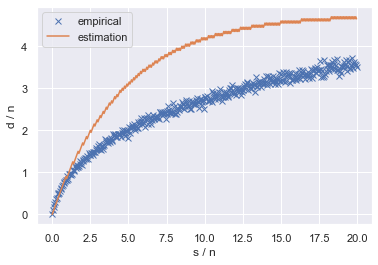

In [612]:
# Plot
plt.plot(_phi, _d, 'x', label='empirical')
plt.plot(_phi, np.array(_estd) / n, '-', label='estimation')
plt.xlabel('s / n')
plt.ylabel('d / n')
#plt.xlim((0, 5))
#plt.ylim((0, 5))
plt.legend()
plt.show()

#### Estimation of $\frac{s}{n}$ and $\frac{d}{n}$ on artificial data

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [01:13<00:00,  2.58it/s]


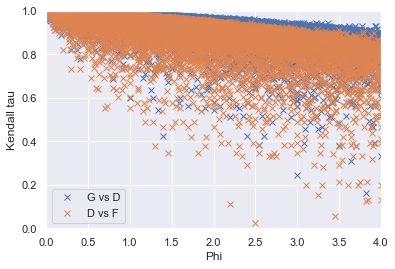

In [3]:
_phi = []
_corr = []
_corr_df = []
for n in tqdm(range(10, 200)):
    for N in range(0, 200):
        g = rk.generator.SwapGenerator()
        g.fit(n)
        _phi.append(N/n)
        _corr.append(rk.corr(g.sample(), g.sample(N=N), method='kendalltau'))
        _corr_df.append(rk.corr(g.sample(N=N), g.sample(N=N), method='kendalltau'))

# PLOT
plt.plot(_phi, _corr, 'x', label='G vs D')
plt.plot(_phi, _corr_df, 'x', label='D vs F')
plt.xlim((0, 4))
plt.ylim((0, 1))
plt.xlabel('Phi')
plt.ylabel('Kendall tau')
plt.legend()
plt.show()

n = 50


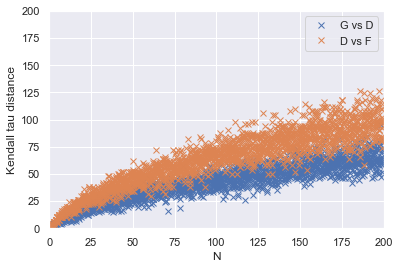

In [20]:
print('n = 50')
_phi = []
_corr = []
_corr_df = []
n = 50
_N = []
_log = []
for N in range(0, 200):
    for _ in range(10): # re-runs
        g = rk.generator.SwapGenerator()
        g.fit(n)
        _N.append(N)
        _corr.append(rk.kendall_tau_distance(g.sample(), g.sample(N=N)))
        _corr_df.append(rk.kendall_tau_distance(g.sample(N=N), g.sample(N=N)))

# PLOT
plt.plot(_N, _corr, 'x', label='G vs D')
plt.plot(_N, _corr_df, 'x', label='D vs F')
plt.xlim((0, 200))
plt.ylim((0, 200))
plt.xlabel('N')
plt.ylabel('Kendall tau distance')
plt.legend()
plt.show()